In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
data = xr.tutorial.load_dataset('air_temperature')
data

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 62.5 60.0 57.5 55.0 52.5 ...
  * lon      (lon) float32 200.0 202.5 205.0 207.5 210.0 212.5 215.0 217.5 ...
  * time     (time) datetime64[ns] 2013-01-01 2013-01-01T06:00:00 ...
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 244.0 244.09999 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [2]:
print(data['time'][0].values, data['time'][-1].values)

2013-01-01T00:00:00.000000000 2014-12-31T18:00:00.000000000


In [3]:
data = data['air']    # There's only one variable anyways

In [4]:
data['lon'] = np.where(data['lon'] > 180, data['lon'] - 360, data['lon'])
data['lon']

<xarray.DataArray 'lon' (lon: 53)>
array([-160. , -157.5, -155. , -152.5, -150. , -147.5, -145. , -142.5, -140. ,
       -137.5, -135. , -132.5, -130. , -127.5, -125. , -122.5, -120. , -117.5,
       -115. , -112.5, -110. , -107.5, -105. , -102.5, -100. ,  -97.5,  -95. ,
        -92.5,  -90. ,  -87.5,  -85. ,  -82.5,  -80. ,  -77.5,  -75. ,  -72.5,
        -70. ,  -67.5,  -65. ,  -62.5,  -60. ,  -57.5,  -55. ,  -52.5,  -50. ,
        -47.5,  -45. ,  -42.5,  -40. ,  -37.5,  -35. ,  -32.5,  -30. ],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -160.0 -157.5 -155.0 -152.5 -150.0 -147.5 -145.0 ...

In [5]:
seasons = data.groupby('time.season').mean(dim='time')
seasons

<xarray.DataArray 'air' (season: 4, lat: 25, lon: 53)>
array([[[247.01007, 246.95503, ..., 242.69449, 244.23262],
        [248.83022, 248.98196, ..., 242.24562, 245.32053],
        ...,
        [296.939  , 296.83542, ..., 295.42157, 294.959  ],
        [297.4473 , 297.49   , ..., 296.13766, 296.05698]],

       [[273.39032, 273.2029 , ..., 266.19952, 267.94702],
        [274.33145, 274.48965, ..., 265.93015, 268.56693],
        ...,
        [298.91702, 298.57843, ..., 297.43808, 297.17545],
        [298.90414, 298.88306, ..., 297.87   , 297.96603]],

       [[258.86465, 258.69296, ..., 249.09572, 250.37955],
        [260.2769 , 260.37476, ..., 249.08131, 251.56924],
        ...,
        [297.43817, 297.3017 , ..., 295.31448, 294.91473],
        [297.8931 , 297.9006 , ..., 295.74725, 295.72275]],

       [[261.96924, 261.61057, ..., 249.53653, 250.96701],
        [267.2477 , 267.07742, ..., 248.85371, 251.75676],
        ...,
        [299.2114 , 299.02353, ..., 298.93045, 298.72104],
  

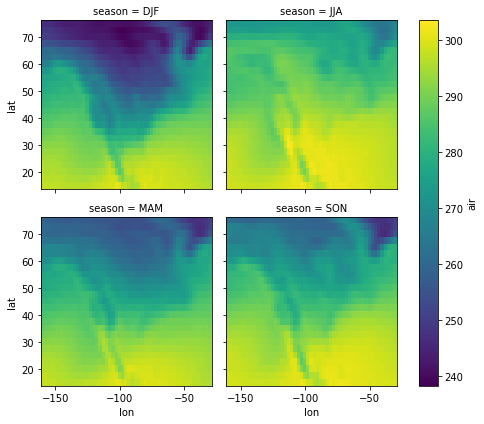

In [6]:
seasons.plot(x='lon', y='lat', col='season', col_wrap=2)

In [7]:
%load_ext fortranmagic

/home/alex/miniconda3/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [8]:
%%fortran

subroutine loops(iarr, total, nx, ny, nz)
    real(kind=8), dimension(nx, ny, nz), intent(in) :: iarr
    real(kind=8), intent(out) :: total
            
    total = 0
    do k = 1, nz
        do j = 1, ny
            do i = 1, nx
                total = total + iarr(i, j, k)
            end do
        end do
    end do
end subroutine loops

In [9]:
def loops_py(iarr):
    nx, ny, nz = iarr.shape
    
    total = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                total += iarr[i, j, k]
    return total

In [10]:
import numpy as np
arr = np.random.rand(100, 100, 400) * 100

In [11]:
# The Fortran loop
farr = np.asfortranarray(arr)  # Convert array to Fortran order
%timeit loops(farr)

7.08 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# The Python loop
%timeit loops_py(arr)

In [ ]:
%load_ext cython

In [ ]:
from numba import jit

@jit
def loops_nb(iarr):
    nx, ny, nz = iarr.shape
    
    total = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                total += iarr[i, j, k]
    return total

In [ ]:
%%cython
import numpy as np
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def loops_cy(double [:, :, :] iarr):
    cdef int nx, ny, nz
    cdef int i, j, k
    cdef double total = 0
    
    nx = iarr.shape[0]
    ny = iarr.shape[1]
    nz = iarr.shape[2]

    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                total += iarr[i, j, k]
    return total

In [ ]:
# The numba loop
%timeit loops_nb(arr)

In [ ]:
# The cython loop
%timeit loops_cy(arr)